In [2908]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import pandas as pd

In [2909]:
def gec(coordinates):
    x_sum = sum(loc[0] for loc in coordinates)
    y_sum = sum(loc[1] for loc in coordinates)
    x_cord = x_sum / len(coordinates)
    y_cord = y_sum / len(coordinates)

    return x_cord, y_cord

In [2910]:
def gmm(coordinate):
    x_axis = []
    y_axis = []
    centroid = []

    for i in coordinate:
        x_axis.append(i[0])
        y_axis.append(i[1])

    centroid.append(np.median(x_axis))
    centroid.append(np.median(y_axis))

    return centroid[0],centroid[1]

In [2911]:
def ecmb(coordinate, border):
    longitude = 0
    latitude = 0
    k=border
    
    for loc in coordinate:
        if loc[0] <= k:
            longitude+= loc[0]
        else:
            longitude+= k
        latitude+= loc[1]
    x_axis = longitude/len(coordinate)
    y_axis = latitude/len(coordinate)
    return x_axis, y_axis

In [2912]:
def calculate_manhattan_median(customers):
    # Extract coordinates of customer locations
    coordinates = [(x, y) for x, y in customers]

    # Calculate median coordinates for rows and columns
    median_row = sorted([x for x, y in coordinates])[len(coordinates) // 2]
    median_column = sorted([y for x, y in coordinates])[len(coordinates) // 2]

    return median_row, median_column

In [2913]:
def mmeb(customer_locations, border_position):
    R = border_position  

    euclidean_locations = [(x, y) for x, y in customer_locations if x < border_position]
    manhattan_locations = [(x, y) for x, y in customer_locations if x >= border_position]

    best_median_row = None
    best_median_column = None
    best_projected_euclidean = None
    best_total_cost = math.inf

    possible_positions = np.linspace(88.4010, 88.4654, num=10)

    # Iterate over possible distinct positions on the border
    for i in possible_positions:

        projected_euclidean = [(border_position, i) for _, _ in euclidean_locations]

        combined_customers = projected_euclidean + manhattan_locations

        median_row, median_column = calculate_manhattan_median(combined_customers)

        total_cost = sum(math.sqrt((x-border_position)**2 + (y-i)**2) for x,y in euclidean_locations) #cost from euclidian to border
        total_cost += sum(abs(x-median_row) + abs(y-median_column) for x,y in combined_customers) #cost from border to manhattan

        # total_cost = sum(math.sqrt((x - median_row)**2 + (y - median_column)**2) for x, y in combined_customers)

        # Update the best result if the current position is better
        if total_cost < best_total_cost:
            best_projected_euclidean = projected_euclidean[0]
            best_total_cost = total_cost
            best_median_row = median_row
            best_median_column = median_column

    return [best_median_row, best_median_column], best_projected_euclidean

In [2914]:
def create_delivary(x,y,n, seed_value = None):
    if seed_value != None:
        random.seed(seed_value)

    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for _ in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append(tuple([x_loc, y_loc]))

    return loc

In [2915]:
def initial_plot(delivery_loc, border, dp=None, route = None):
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    # plot the border
    plt.plot((border[0][0],border[1][0]), (border[0][1],border[1][1]), c="black")

    if dp!= None:
        plt.scatter(dp[0], dp[1], c="orange")

    if route != None:
        for i in range(len(route)-1):
            f_pt = np.array([route[i][0], route[i+1][0]])
            s_pt = np.array([route[i][1], route[i+1][1]])
            plt.plot(f_pt, s_pt, c="gray")
    plt.title("Delivery Locations")
    # plt.show()

In [2916]:
def geometric_median(delivary_points,initial_guess,border, eps=1e-5):
    # Initial guess for the geometric median
    points = []

    for point in delivary_points:
        if point[0] < border:
            points.append(point)
        else:
            points.append([border, point[1]])

    # guess = np.mean(points, axis=0)
    guess = np.array(initial_guess)
    
    while True:
        # Calculate distances from current guess to all points
        distances = np.linalg.norm(points - guess, axis=1)
        
        # Avoid division by zero
        if np.sum(distances) == 0:
            return guess
        
        # Calculate weights as inverse distances
        weights = 1 / distances
        
        # Calculate weighted average
        new_guess = np.sum(points * weights[:, np.newaxis], axis=0) / np.sum(weights)
        
        # Check for convergence
        if np.linalg.norm(new_guess - guess) < eps:
            return new_guess
        
        print("next dp :", new_guess)
        guess = new_guess

In [2917]:
def create_route(delivery_loc,border,dp,euclidean_points, manhattan_points, border_point = None):
    route = []
    if dp[0] < border :

        for point in delivery_loc :
            route.append(dp)
            if point[0] < border :
                route.append(tuple(point))
            else:
                route.append(tuple([border, point[1]]))
                route.append(tuple([point[0], point[1]]))
                route.append(tuple([border, point[1]]))

        route.append(tuple(dp))
    else:
        for point in manhattan_points:
            route.append(tuple(dp))
            route.append(tuple([dp[0], point[1]]))
            route.append(tuple(point))
            route.append(tuple([dp[0], point[1]]))

        for point in euclidean_points:
            route.append(tuple(dp))
            route.append(tuple([dp[0],border_point[1]]))
            route.append(tuple(border_point))
            route.append(tuple(point))
            route.append(tuple(border_point))
            route.append(tuple([dp[0],border_point[1]]))

        route.append(tuple(dp))

    return route

In [2918]:
def euclidean_distance(source, destination):
    return np.sqrt((source[0]-destination[0])**2 + (source[1]-destination[1])**2)

In [2919]:
def total_distance(route):
    distance = 0
    for i in range(len(route)-1):
        distance += euclidean_distance(route[i], route[i+1])

    return distance

In [2920]:
def optimal_approach(bottom_left, top_right, delivery_loc,border,euclidean_points,manhattan_points,border_point, step=0.0001):
    x1, y1 = bottom_left
    x2, y2 = top_right

    optimal_dp = None
    optimal_route = None
    optimal_distance = math.inf
    
    # Generate the range of x and y values with the specified step size
    x_values = np.arange(x1, x2 + step, step)
    y_values = np.arange(y1, y2 + step, step)
    
    # Iterate over the range of x and y values
    for x in x_values:
        for y in y_values:
            dp = (x,y)
            route = create_route(delivery_loc, border, dp, euclidean_points, manhattan_points, [border,dp[1]])
            distance = total_distance(route)
            if distance < optimal_distance :
                optimal_dp = dp
                optimal_distance = distance
                optimal_route = route

    return optimal_dp, optimal_route, optimal_distance

## Input

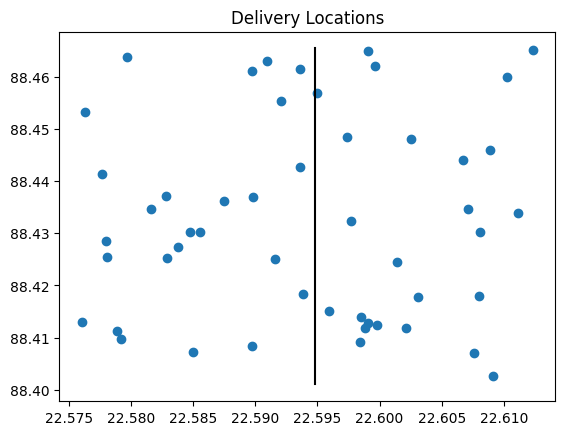

In [2921]:
n = 50

# creating the boundary
x = [22.5726, 88.4010]
y = [22.6141, 88.4654]
border = [[22.5948, 88.4010],[22.5948, 88.4654]]
delivery_loc = create_delivary(x, y, n)
# delivery_loc = create_delivary(x,[border[0][0],y[1]],n)
# delivery_loc = create_delivary([border[0][0],x[1]],y,n)

# Visualize the data
initial_plot(delivery_loc,border)

In [2922]:
euclidean_points = [points for points in delivery_loc if points[0] < border[0][0]]
manhattan_points = [points for points in delivery_loc if points[0] >= border[0][0]]

len(euclidean_points), len(manhattan_points)

(25, 25)

In [2923]:
initial_dp = None
border_point = None

if(len(euclidean_points) == n) :
    initial_dp = gec(delivery_loc)
elif(len(manhattan_points) == n):
    initial_dp = gmm(delivery_loc)
elif(len(euclidean_points) > len(manhattan_points)):
    initial_dp = ecmb(delivery_loc, border[0][0])
else :
    initial_dp, border_point = mmeb(delivery_loc, border[0][0])

In [2924]:
initial_dp

[22.594935397232664, 88.42962222222222]

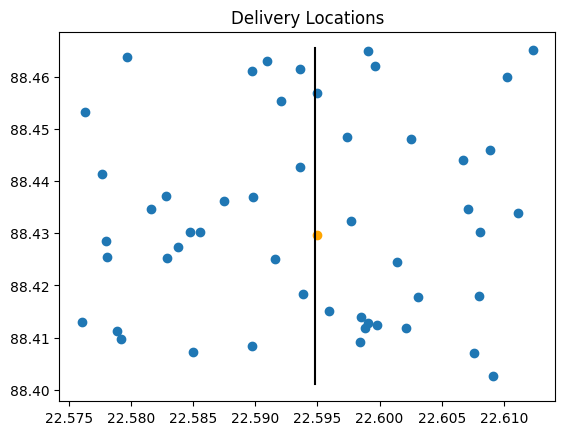

In [2925]:
initial_plot(delivery_loc,border,dp=initial_dp)

In [2926]:
route_1 = create_route(delivery_loc,border[0][0],initial_dp, euclidean_points, manhattan_points, border_point=border_point if border_point != None else None)

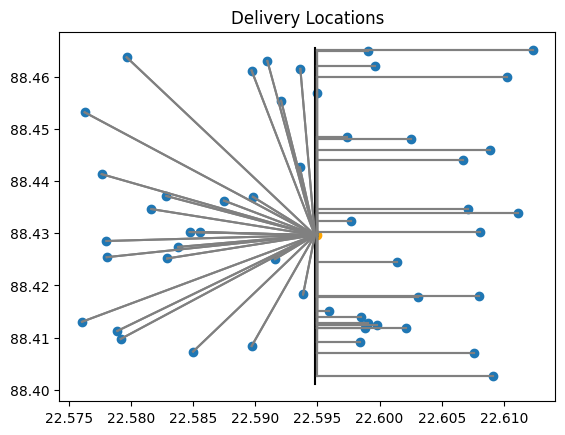

In [2927]:
initial_plot(delivery_loc, border, initial_dp, route_1)

In [2928]:
final_dp = geometric_median(delivery_loc, initial_dp, border[0][0])

final_dp

next dp : [22.59206102 88.43036519]
next dp : [22.59062586 88.43077099]
next dp : [22.59002067 88.43097217]
next dp : [22.5897668  88.43107255]
next dp : [22.58966002 88.43112267]
next dp : [22.58961521 88.43114795]
next dp : [22.58959651 88.43116091]
next dp : [22.58958878 88.43116766]


array([22.58958563, 88.43117125])

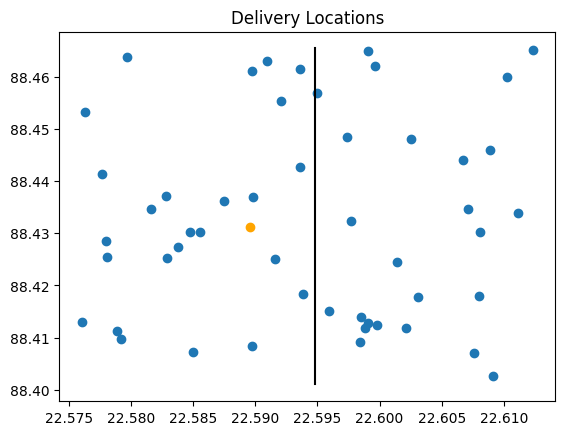

In [2929]:
initial_plot(delivery_loc,border,dp=list(final_dp))

In [2930]:
route_2 = create_route(delivery_loc,border[0][0],final_dp, euclidean_points, manhattan_points, border_point=border_point if border_point != None else None)

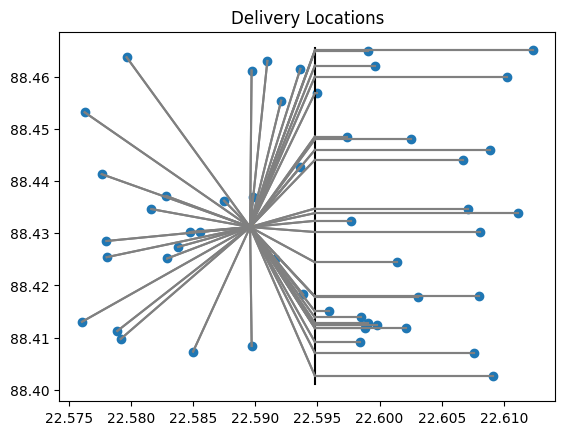

In [2931]:
initial_plot(delivery_loc, border, list(final_dp), route_2)

In [2932]:
# optimal_dp, optimal_route, optimal_distance = optimal_approach(x, y, delivery_loc,border[0][0],euclidean_points,manhattan_points,border_point)

# optimal_dp

In [2933]:
# optimal_distance

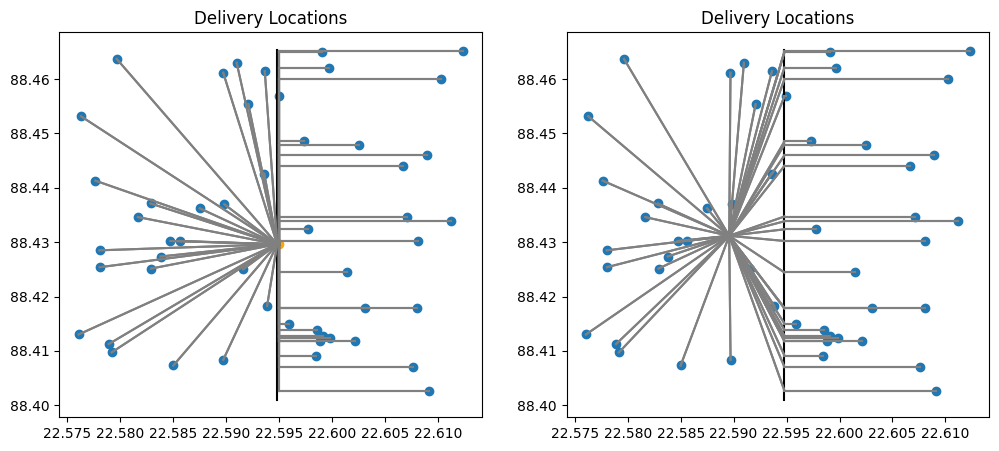

In [2934]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
initial_plot(delivery_loc, border, initial_dp, route_1)
plt.subplot(1,2,2)
initial_plot(delivery_loc, border, list(final_dp), route_2)
plt.show()

In [2935]:
distance_1 = total_distance(route_1)

distance_2 = total_distance(route_2)

print("Distance before dp pruning :", distance_1)
print("Distance after dp pruning :", distance_2)
# print("Brutforce Distance :",optimal_distance)

Distance before dp pruning : 2.2698008169898283
Distance after dp pruning : 2.195724415374274


In [2936]:
df = pd.read_csv('./last_mile_performance_improvement.csv')

new_row = {
    'total_delivary':n,
    'euclidean_points':len(euclidean_points),
    'manhattan_points':len(manhattan_points),
    'distance':distance_1,
    'optimized_distance':distance_2
}

df.loc[len(df)] = new_row

df.tail()

,total_delivary,euclidean_points,manhattan_points,distance,optimized_distance,brutforce_distance
77,50,31,19,2.297755,2.277808,NaN
78,50,19,31,2.003722,2.023311,NaN
79,50,23,27,2.325875,2.305245,NaN
80,50,27,23,2.337831,2.329531,NaN
81,50,25,25,2.269801,2.195724,NaN


In [2937]:
try:
    df.to_csv('./last_mile_performance_improvement.csv', index=False)
except:
    print("Unknown error occurs")